https://www.kaggle.com/spaics/hackathon-blossom-flower-classification

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import copy
import json

In [0]:
transform=transforms.Compose([
                              transforms.RandomResizedCrop(224),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [0]:
X = []
y = []

with open('./drive/My Drive/flower/g.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        X.append(name)
        y.append(lang)

In [0]:
classes=tuple(y)
num_classes=102

In [0]:
trainset=torchvision.datasets.ImageFolder(root='./drive/My Drive/flower/flower_data/flower_data/train',transform=transform)
testset=torchvision.datasets.ImageFolder(root='./drive/My Drive/flower/test set',transform=transform)

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([5, 3, 224, 224])
torch.Size([3, 224, 224])
72


In [0]:
img = images[1]

In [0]:
npimg = img.numpy()
print(npimg.shape)  

(3, 224, 224)


In [0]:
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

(224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


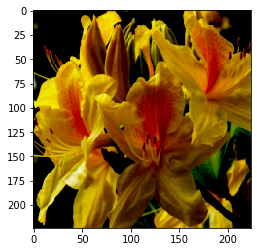

In [0]:
plt.figure(figsize = (4,4))
plt.imshow(npimg)
plt.show()

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


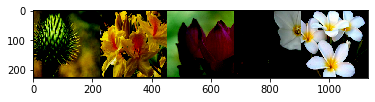

monkshood water lily ruby-lipped cattleya silverbush hibiscus


In [0]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(5)))

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation(dataloader,model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
vgg=models.vgg16_bn(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
for param in vgg.parameters():
    param.requires_grad = False

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [0]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([102, 4096])
torch.Size([102])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [0]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(10000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 4.75
Iteration: 0/625, Loss: 4.75
Min loss 4.73
Min loss 4.49
Min loss 4.19
Min loss 4.08
Min loss 3.94
Min loss 3.78
Min loss 3.72
Min loss 3.53
Min loss 3.05
Min loss 2.97
Min loss 2.76
Min loss 2.49
Min loss 2.13
Min loss 1.61
Min loss 1.57
Min loss 1.32
Iteration: 100/625, Loss: 2.10
Min loss 1.22
Min loss 1.06
Iteration: 200/625, Loss: 2.22
Min loss 1.02
Min loss 0.98
Min loss 0.80
Iteration: 300/625, Loss: 1.73
Min loss 0.78
Min loss 0.34
Iteration: 400/625, Loss: 1.33


In [0]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

71.7032967032967 0.0


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.01)

In [0]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(10000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 1.03
Iteration: 0/625, Loss: 1.03
Min loss 0.99
Min loss 0.46
Iteration: 100/625, Loss: 1.02
Iteration: 200/625, Loss: 0.59
Iteration: 300/625, Loss: 0.62
Min loss 0.43
Min loss 0.43
Iteration: 400/625, Loss: 1.11


In [0]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

76.25152625152626 0.970873786407767


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.001)

In [0]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(10000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

Min loss 1.16
Iteration: 0/625, Loss: 1.16
Min loss 0.48
Min loss 0.47
Min loss 0.42
Iteration: 100/625, Loss: 0.42
Iteration: 200/625, Loss: 1.72
Min loss 0.41
Iteration: 300/625, Loss: 0.95
Iteration: 400/625, Loss: 0.54


In [0]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

76.75518925518925 0.0
